In [ ]:
import torch
from torch import nn, optim
import torch_directml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
torch.manual_seed(42)
torch.cuda.manual_seed(42)
print(torch.__version__)
if torch.cuda.is_available():
    print(f"CUDA is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs: {gpu_count}")
    # model = nn.DataParallel(model)  # Uncomment if using multiple GPUs
elif torch_directml.is_available():
    print(f"DirectML is available. Device: {torch_directml.device()}")
    device = torch_directml.device()
    gpu_count = torch_directml.device_count()
    print(f"Number of DirectML devices: {gpu_count}")
else:
    print("CUDA not available, using CPU.")
    device = "cpu"
print(device)

2.4.1+cpu
DirectML is available. Device: privateuseone:0
Number of DirectML devices: 1
privateuseone:0


In [32]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor and scale to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load MNIST dataset
train_dataset = datasets.MNIST(
    root='data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = datasets.MNIST(
    root='data', 
    train=False, 
    download=True, 
    transform=transform
)

In [48]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training samples: 60000
Test samples: 10000
Number of classes: 10


In [49]:
# Define CNN Model
class MNISTNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 14x14 -> 14x14
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)  # 7x7 after two pooling operations
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))  # 28x28x32
        x = self.pool(x)              # 14x14x32
        
        # Second conv block
        x = self.relu(self.conv2(x))  # 14x14x64
        x = self.pool(x)              # 7x7x64
        
        # Third conv block
        x = self.relu(self.conv3(x))  # 7x7x128
        x = self.dropout1(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)     # Flatten: batch_size x (128*7*7)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

# Initialize model, loss function, and optimizer
model_gpu = MNISTNet().to(device)
model_cpu = MNISTNet().cpu()
loss_fn = nn.CrossEntropyLoss()
optimizer_gpu = optim.Adam(model_gpu.parameters(), lr=0.1)
optimizer_cpu = optim.Adam(model_cpu.parameters(), lr=0.1)

print(model_gpu)
print(model_cpu)

MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)
MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features

In [55]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device = torch.device('cpu')):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 200 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Testing function
def test_model(model, test_loader, criterion, device= torch.device('cpu')):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [57]:
# Training loop
epochs = 0
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [58]:
for _ in range(5):
    epochs += 1
    print(f'\nEpoch {epochs}')
    print('-' * 30)
    
    # Train
    train_loss, train_acc = train_model(model_gpu, train_loader, loss_fn, optimizer_gpu, device)
    
    # Test
    test_loss, test_acc = test_model(model_gpu, test_loader, loss_fn, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

print("\nTraining completed!")


Epoch 1
------------------------------
Batch 0/938, Loss: 2.3088
Batch 200/938, Loss: 2.3078
Batch 400/938, Loss: 2.2927
Batch 600/938, Loss: 2.2921
Batch 800/938, Loss: 2.2966
Train Loss: 2.3102, Train Acc: 10.36%
Test Loss: 2.3234, Test Acc: 9.58%

Epoch 2
------------------------------
Batch 0/938, Loss: 2.3548
Batch 200/938, Loss: 2.3647
Batch 400/938, Loss: 2.2950
Batch 600/938, Loss: 2.3568
Batch 800/938, Loss: 2.3094
Train Loss: 2.3098, Train Acc: 10.36%
Test Loss: 2.3110, Test Acc: 10.32%

Epoch 3
------------------------------
Batch 0/938, Loss: 2.3230
Batch 200/938, Loss: 2.3015
Batch 400/938, Loss: 2.2798
Batch 600/938, Loss: 2.3291
Batch 800/938, Loss: 2.3192
Train Loss: 2.3101, Train Acc: 10.28%
Test Loss: 2.3036, Test Acc: 11.35%

Epoch 4
------------------------------
Batch 0/938, Loss: 2.2734
Batch 200/938, Loss: 2.3093
Batch 400/938, Loss: 2.2948
Batch 600/938, Loss: 2.2904
Batch 800/938, Loss: 2.3093
Train Loss: 2.3107, Train Acc: 10.18%
Test Loss: 2.3082, Test Acc: 

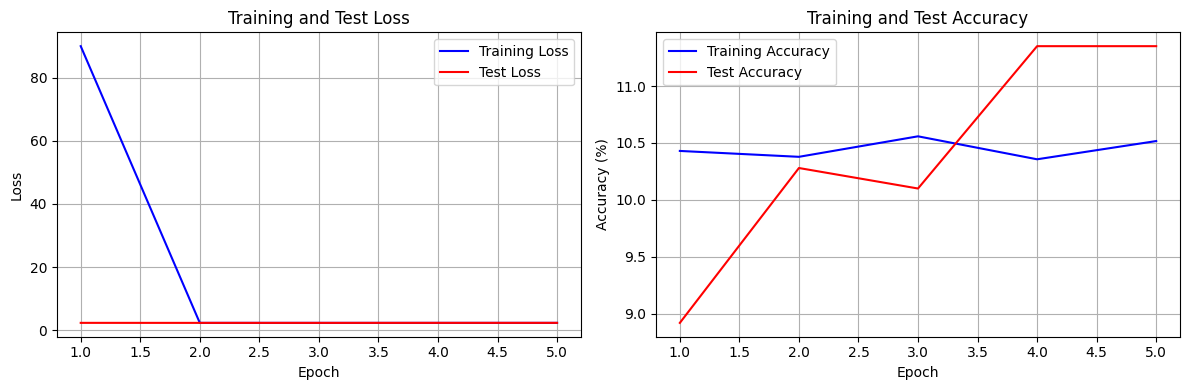

In [40]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
ax1.plot(range(1, epochs+1), test_losses, 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(range(1, epochs+1), train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(range(1, epochs+1), test_accuracies, 'r-', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

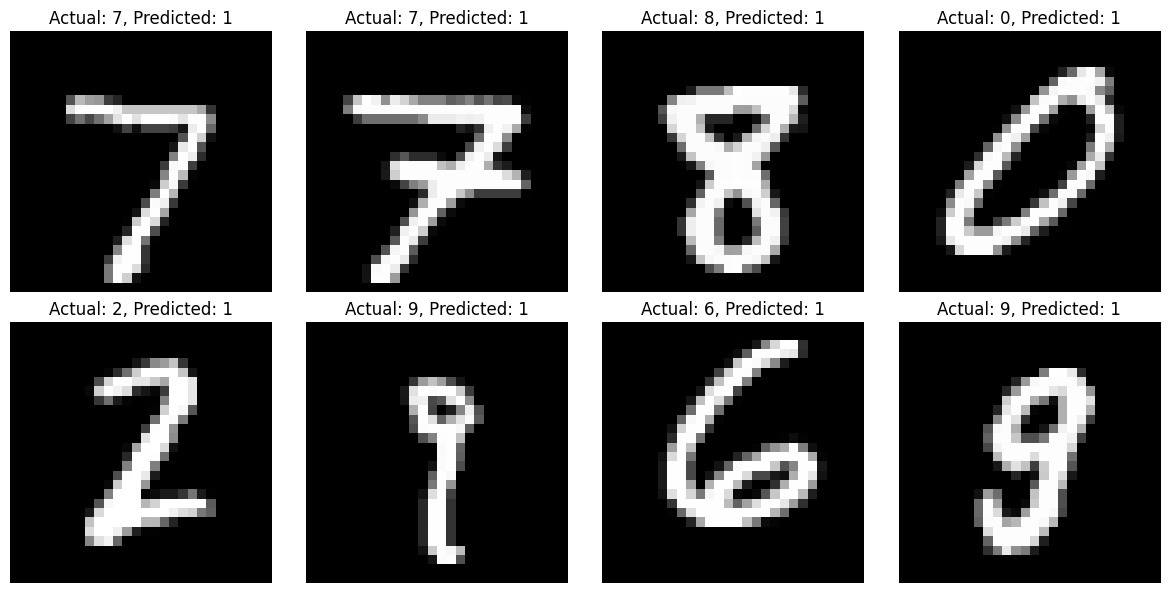

In [42]:
# Visualize some predictions
def visualize_predictions(model, test_loader, device=torch.device('cpu'), num_images=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_images:
                break
                
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            # Get first image from batch
            img = data[0].cpu().squeeze()
            actual = target[0].cpu().item()
            pred = predicted[0].cpu().item()
            
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'Actual: {actual}, Predicted: {pred}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model_cpu, test_loader)